In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Create TF dataset form images in directory
batch_size = 32
img_size = (160, 160)
directory = '/kaggle/input/dog-breeds/dog-breeds'

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=img_size,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=321)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=img_size,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=321)

Found 541 files belonging to 8 classes.
Using 433 files for training.
Found 541 files belonging to 8 classes.
Using 108 files for validation.


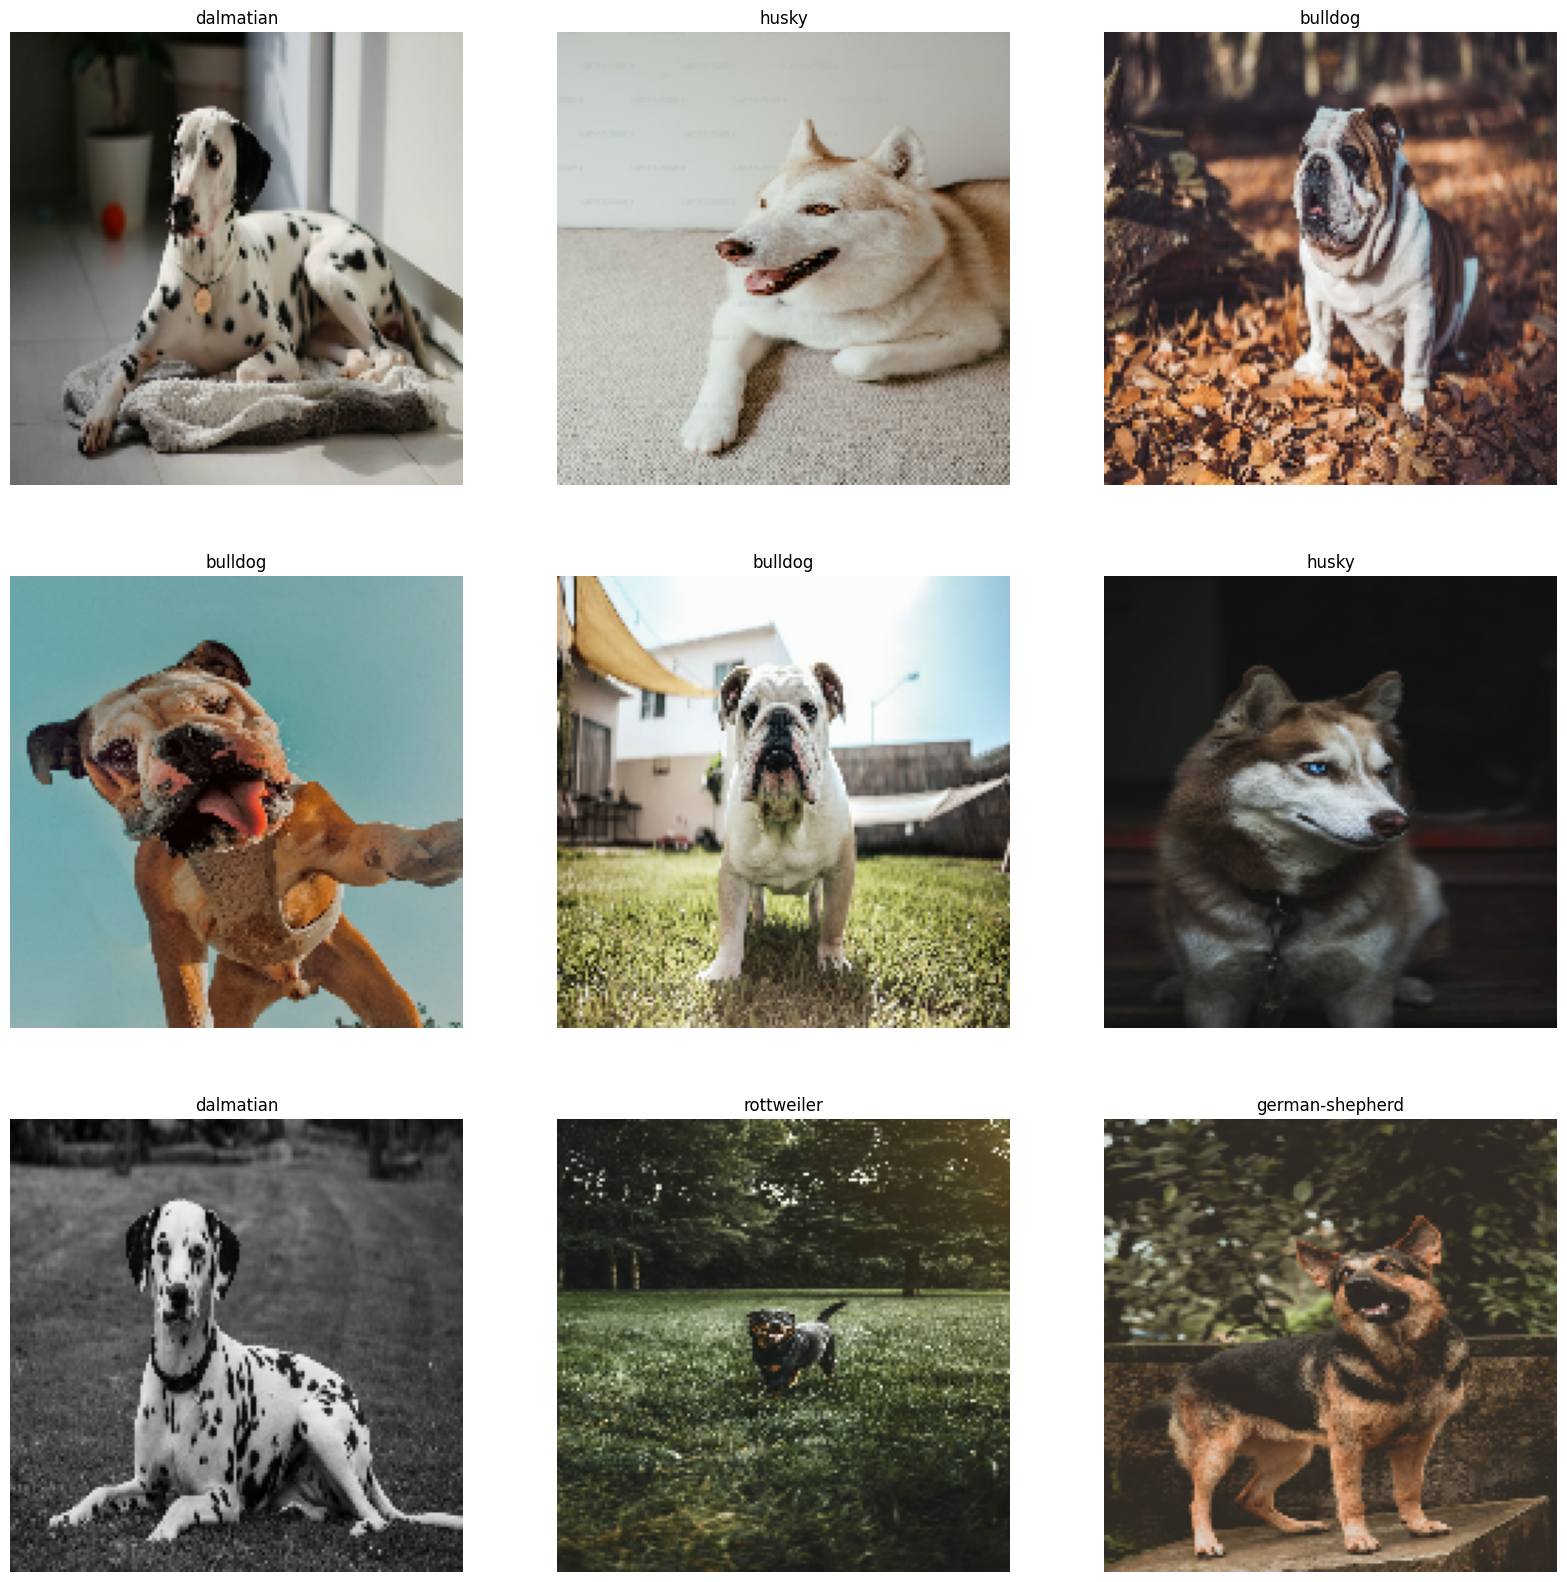

In [3]:
#View images
class_names = train_dataset.class_names

plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [4]:
#Create one hot matrix 
train_dataset = train_dataset.map(lambda x, y: (x, tf.cast(tf.one_hot(y, 8), tf.uint8)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.cast(tf.one_hot(y, 8), tf.uint8)))

In [5]:
#Data augmenter function
def data_augmenter():
    '''
    TF Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

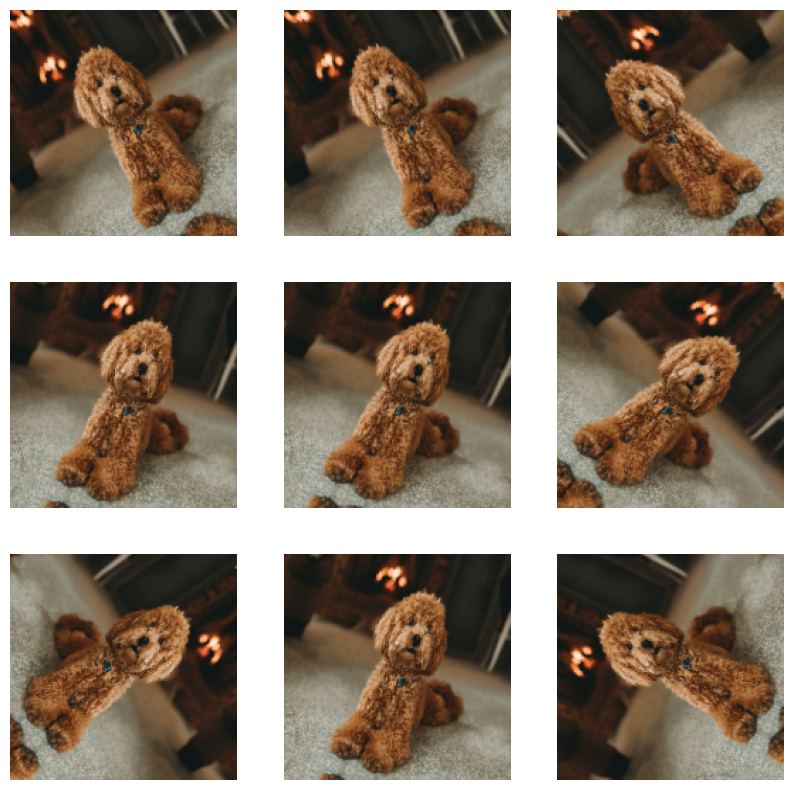

In [6]:
#Preview Data augmentation
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')


In [7]:
#Preprocess images to match MobileNetV2 normalization
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
#Prepare dataset and get MobileNetV2 as base model
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

img_shape = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 1s 0us/step


In [9]:
#Model Summary
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [10]:
#Create dog model by deleting top layer of MobileNetV2, freezing base model and training only new top layer
def dog_model(image_shape=img_size, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    
    #Freeze the base model
    base_model.trainable = False

    #Create the input layer
    inputs = tf.keras.Input(shape=input_shape) 
    
    #Apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    #Data preprocessing
    x = preprocess_input(x) 
    
    x = base_model(x, training=False) 
    
    #Add the new Binary classification layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #Dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    #Prediction layer
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [11]:
#Create the model and compile
model = dog_model(img_size, data_augmentation)

base_learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


In [12]:
#Train the model
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
14/14 [==============================] - 11s 417ms/step - loss: 1.8216 - accuracy: 0.3603 - val_loss: 0.7974 - val_accuracy: 0.8611
Epoch 2/5
14/14 [==============================] - 6s 337ms/step - loss: 0.7525 - accuracy: 0.7806 - val_loss: 0.3147 - val_accuracy: 0.9352
Epoch 3/5
14/14 [==============================] - 6s 326ms/step - loss: 0.4360 - accuracy: 0.8776 - val_loss: 0.1770 - val_accuracy: 0.9722
Epoch 4/5
14/14 [==============================] - 6s 330ms/step - loss: 0.3060 - accuracy: 0.9122 - val_loss: 0.1227 - val_accuracy: 0.9815
Epoch 5/5
14/14 [==============================] - 6s 329ms/step - loss: 0.2143 - accuracy: 0.9469 - val_loss: 0.1001 - val_accuracy: 1.0000


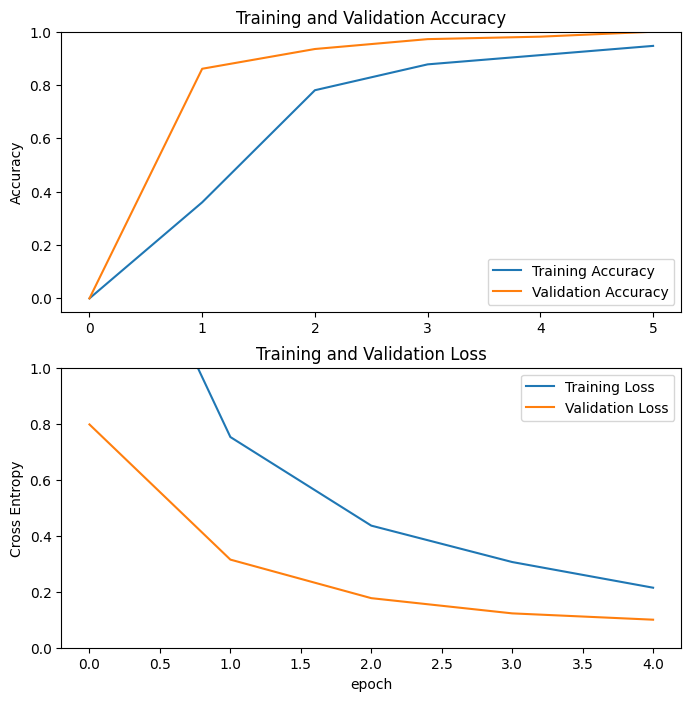

In [13]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
#Fine Tune model for better results
base_model = model.layers[4]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 153

# Freeze all the layers before
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
loss_function= tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(lr=0.01*base_learning_rate)

metrics=['accuracy']



model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [15]:
#Train the fine tuned model
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
14/14 [==============================] - 10s 386ms/step - loss: 0.2246 - accuracy: 0.9469 - val_loss: 0.0682 - val_accuracy: 0.9907
Epoch 6/10
14/14 [==============================] - 6s 330ms/step - loss: 0.1622 - accuracy: 0.9492 - val_loss: 0.0577 - val_accuracy: 0.9907
Epoch 7/10
14/14 [==============================] - 6s 331ms/step - loss: 0.1120 - accuracy: 0.9654 - val_loss: 0.0519 - val_accuracy: 1.0000
Epoch 8/10
14/14 [==============================] - 6s 313ms/step - loss: 0.1289 - accuracy: 0.9584 - val_loss: 0.0479 - val_accuracy: 1.0000
Epoch 9/10
14/14 [==============================] - 6s 331ms/step - loss: 0.0889 - accuracy: 0.9700 - val_loss: 0.0403 - val_accuracy: 1.0000
Epoch 10/10
14/14 [==============================] - 6s 336ms/step - loss: 0.0842 - accuracy: 0.9815 - val_loss: 0.0459 - val_accuracy: 0.9907


In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

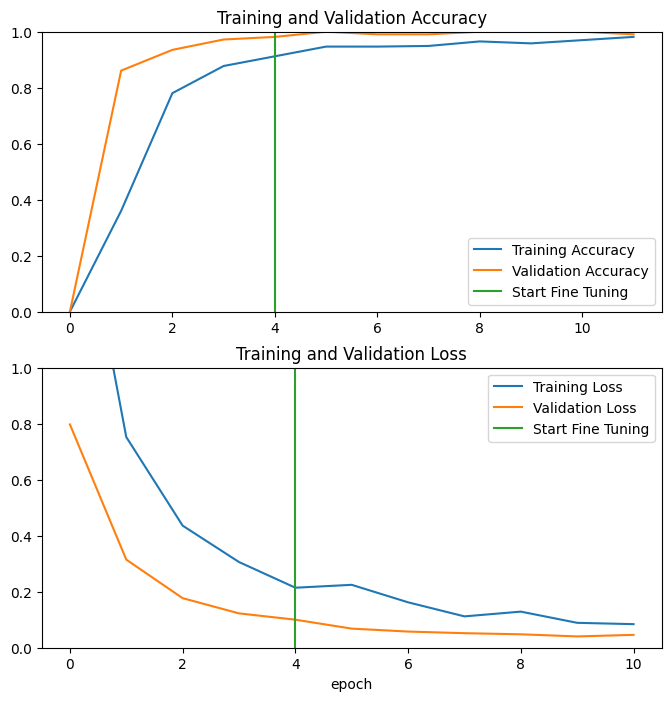

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()